In [274]:
#Standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

#AIF360 Dataset Classes 
from aif360.datasets import StandardDataset
from aif360.datasets import BinaryLabelDataset

#AIF360 Metrics Classes  
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.metrics import ClassificationMetric

#AIF360 Algorithms 
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing
# AI360 Explainers
from aif360.explainers import MetricTextExplainer

#Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score


#Tensorflow -- install version before 2.0
import tensorflow as tf 

#For Markdown
from IPython.display import Markdown, display

#Helper Functions
from src.classifier_functions import *
from src.dataset_functions import *
from src.fair_classifier_functions import *


### Creating the Datasets to Analyze with AIF 360

In [73]:
data = create_multiple_datasets(create_binary_dataset_salary, [150000, 200000])

In [74]:
train, val, test = create_split_lists(data)

In [75]:
train_mean, train_di = get_dataset_metrics_list(train)

In [76]:
val_mean, val_di = get_dataset_metrics_list(val)

In [77]:
## Getting the Initial Metrics between the Training Set and the Validation Set

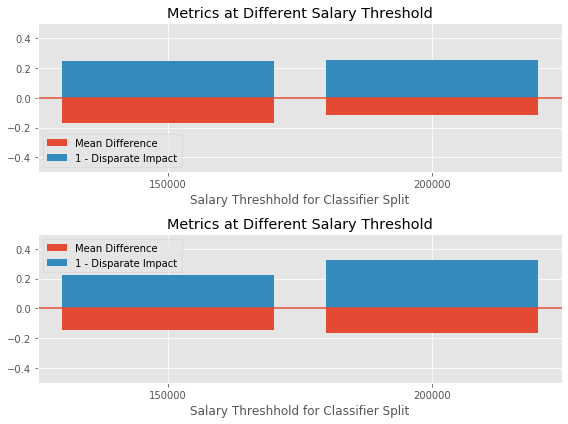

In [78]:
plot_mean_diff_and_di(train_mean, train_di, val_mean, val_di, 'images/initial_metrics.png')

## Creating Predictions from a Random Forest Classifier 

In [79]:
pred_list = get_predictions(RandomForestClassifier(n_estimators=500, max_depth=5), 
                train, val)

In [80]:
pred_mean, pred_di = val_mean, val_di = get_dataset_metrics_list(pred_list)

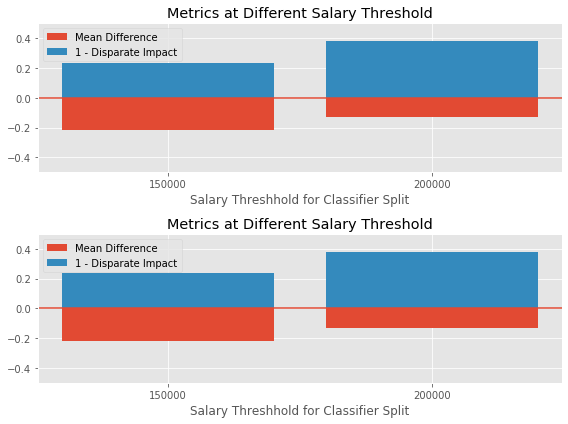

In [95]:
plot_mean_diff_and_di(val_mean, val_di, pred_mean, pred_di, 'images/initial_rf_metrics.png')

## Reweighing to Reduce Bias

In [85]:
privileged_groups= [{'sex':1}]
unprivileged_groups= [{'sex': 0}]
RW = Reweighing(unprivileged_groups=unprivileged_groups, 
               privileged_groups=privileged_groups)

rw_train_datasets = []
for dataset in train: 
    rw = RW.fit_transform(dataset)
    rw_train_datasets.append(rw)
    
rw_val_datasets = [] 
for dataset in val: 
    rw = RW.fit_transform(dataset)
    rw_val_datasets.append(rw)

In [86]:
rw_train_mean, rw_train_di = get_dataset_metrics_list(rw_train_datasets)
rw_val_mean, rw_val_di = get_dataset_metrics_list(rw_val_datasets)


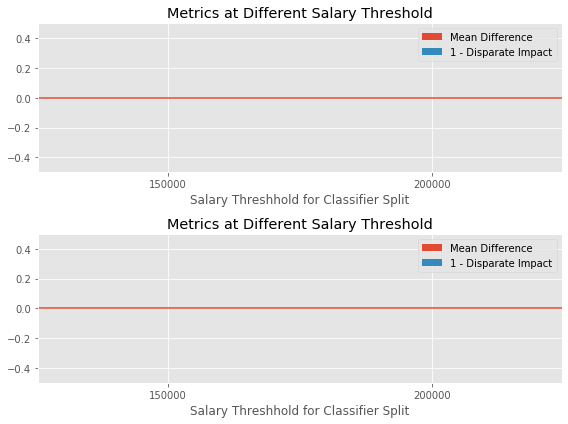

In [94]:
plot_mean_diff_and_di(rw_train_mean, rw_train_di, rw_val_mean, rw_val_di, 'images/rw_metrics.png')

### New Predictions with Reweighted Random Forest

In [223]:
rw_pred_list = get_rw_predictions(RandomForestClassifier(n_estimators=500, max_depth=5), rw_train_datasets, rw_val_datasets)

In [232]:
rw_pred_mean, rw_pred_di = get_dataset_metrics_list(rw_pred_list)

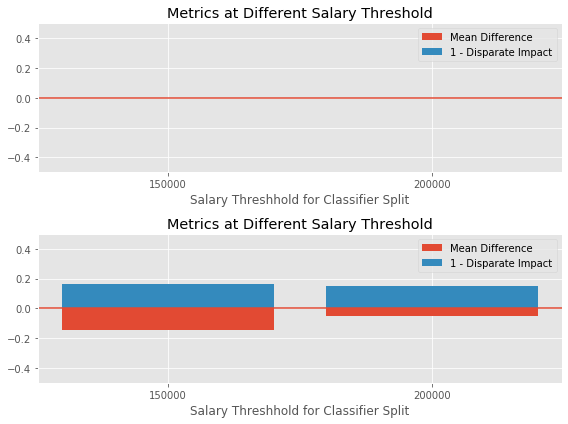

In [93]:
plot_mean_diff_and_di(rw_val_mean, rw_val_di, rw_pred_mean, rw_pred_di, 'images/rw_rf_metrics.png')

### Inprocessing with Adversarial Debiasing 

In [102]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()

In [103]:
##Creating Tensorflow Session - must not use Tensorflow 2.0 
sess = tf.Session()
db_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                            num_epochs  = 100,
                            batch_size = 50,
                            adversary_loss_weight = .1,     
                            debias=True,
                          sess=sess)

In [104]:
db_model.fit(train[0]) 

epoch 0; iter: 0; batch classifier loss: 0.786667; batch adversarial loss: 0.722030
epoch 1; iter: 0; batch classifier loss: 0.566234; batch adversarial loss: 0.722569
epoch 2; iter: 0; batch classifier loss: 0.517358; batch adversarial loss: 0.679097
epoch 3; iter: 0; batch classifier loss: 0.579061; batch adversarial loss: 0.639539
epoch 4; iter: 0; batch classifier loss: 0.557821; batch adversarial loss: 0.730436
epoch 5; iter: 0; batch classifier loss: 0.560512; batch adversarial loss: 0.610696
epoch 6; iter: 0; batch classifier loss: 1.258147; batch adversarial loss: 0.630485
epoch 7; iter: 0; batch classifier loss: 0.420474; batch adversarial loss: 0.647166
epoch 8; iter: 0; batch classifier loss: 0.502699; batch adversarial loss: 0.691675
epoch 9; iter: 0; batch classifier loss: 0.323698; batch adversarial loss: 0.664401
epoch 10; iter: 0; batch classifier loss: 0.411229; batch adversarial loss: 0.580769
epoch 11; iter: 0; batch classifier loss: 0.570438; batch adversarial loss:

In [105]:
adb_preds_1 = db_model.predict(val[0])

In [108]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()
db_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                            num_epochs  = 100,
                            batch_size = 50,
                            adversary_loss_weight = .1,     
                            debias=True,
                          sess=sess)

db_model.fit(train[1]) 

epoch 0; iter: 0; batch classifier loss: 0.734811; batch adversarial loss: 0.638351
epoch 1; iter: 0; batch classifier loss: 0.567719; batch adversarial loss: 0.691972
epoch 2; iter: 0; batch classifier loss: 0.699026; batch adversarial loss: 0.666733
epoch 3; iter: 0; batch classifier loss: 0.695253; batch adversarial loss: 0.686338
epoch 4; iter: 0; batch classifier loss: 0.561558; batch adversarial loss: 0.602180
epoch 5; iter: 0; batch classifier loss: 0.632185; batch adversarial loss: 0.591762
epoch 6; iter: 0; batch classifier loss: 0.664400; batch adversarial loss: 0.576407
epoch 7; iter: 0; batch classifier loss: 0.585982; batch adversarial loss: 0.679928
epoch 8; iter: 0; batch classifier loss: 0.615957; batch adversarial loss: 0.625531
epoch 9; iter: 0; batch classifier loss: 0.579121; batch adversarial loss: 0.649285
epoch 10; iter: 0; batch classifier loss: 0.566573; batch adversarial loss: 0.715885
epoch 11; iter: 0; batch classifier loss: 0.587230; batch adversarial loss:

In [111]:
adb_preds_2 = db_model.predict(val[1])


In [113]:
adb_preds = [adb_preds_1, adb_preds_2]

In [114]:
adb_mean, adb_di = get_dataset_metrics_list(adb_preds)


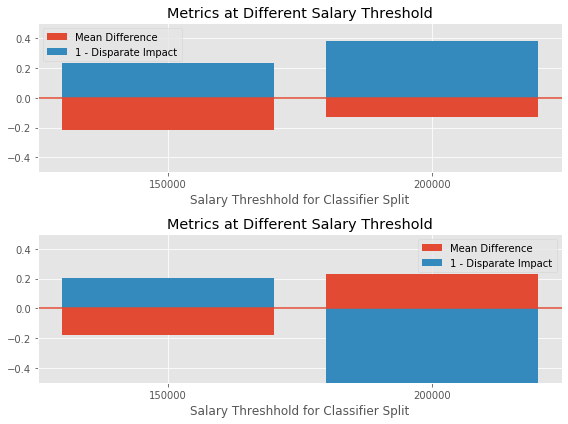

In [151]:
plot_mean_diff_and_di(val_mean, val_di, adb_mean, adb_di, 'images/adb_metrics.png')

## Inprocessing PrejudiceRemover

In [123]:
pr = PrejudiceRemover(sensitive_attr='sex', class_attr='salary')
pr.fit(train[0])
pr2 = PrejudiceRemover(sensitive_attr='sex', class_attr='salary')
pr2.fit(train[1])

In [124]:
pr_preds_1 = pr.predict(val[0])
pr_preds_2 = pr2.predict(val[1])
pr_preds = [pr_preds_1, pr_preds_2]


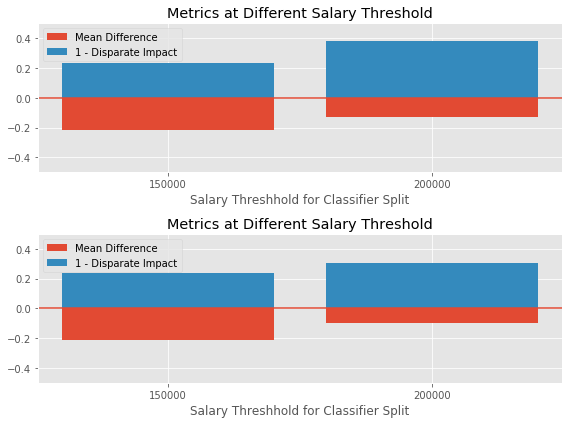

In [150]:
pr_mean, pr_di = get_dataset_metrics_list(pr_preds)
plot_mean_diff_and_di(val_mean, val_di, pr_mean, pr_di, 'images/pr_metrics.png')

### PostProcessing with Calibrated Odd Postprocessing

#### With Random Forest Predictions

In [132]:
cpp_rf = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint='weighted')
cpp2_rf = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint='weighted')

cpp_rf = cpp.fit(val[0], pred_list[0])
cpp2_rf = cpp2.fit(val[1], pred_list[1])

In [147]:
cpp_preds_rf_1 = cpp.predict(pred_list[0])
cpp_preds_rf_2 = cpp.predict(pred_list[1])
cpp_rf_preds = [cpp_preds_rf_1, cpp_preds_rf_2]


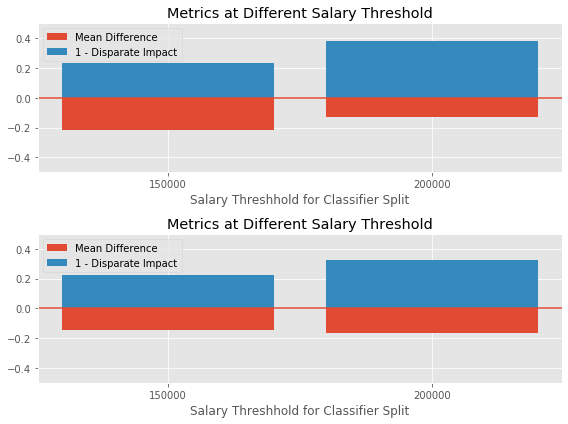

In [152]:
cpp_rf_mean, cpp_rf_di = get_dataset_metrics_list(cpp_rf_preds)
plot_mean_diff_and_di(val_mean, val_di, cpp_rf_mean, cpp_rf_di, 'images/cpp_rf_metrics.png')

In [142]:
cpp_rf_di

[0.22534393837468503, 0.3279949494087736]

#### With Adversarial Debiasing Predictions 


In [290]:
cpp_adb = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint='weighted')
cpp2_adb = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint='weighted')

cpp_adb = cpp.fit(val[0],adb_preds[0])
cpp2_adb = cpp2.fit(val[1], adb_preds[1])

In [291]:
cpp_preds_adb_1 = cpp.predict(adb_preds[0])
cpp_preds_adb_2 = cpp.predict(adb_preds[1])
cpp_adb_preds = [cpp_preds_adb_1, cpp_preds_adb_2]

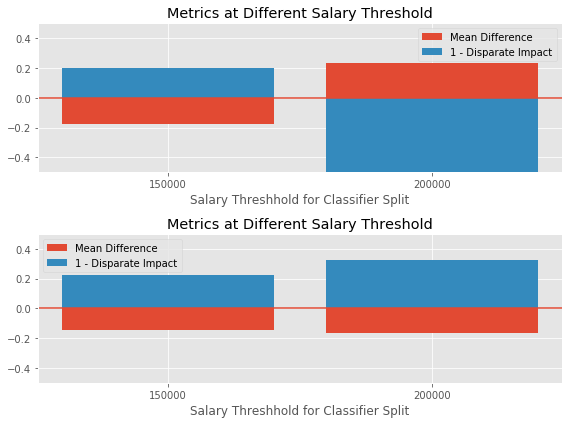

In [292]:
cpp_adb_mean, cpp_adb_di = get_dataset_metrics_list(cpp_adb_preds)
plot_mean_diff_and_di(adb_mean, adb_di, cpp_adb_mean, cpp_adb_di, 'images/cpp_adb_metrics.png')

### Reviewing the Overall Metrics to Choose the Best Model

In [293]:
rf_metrics = get_classifier_metrics(val, pred_list)
rf_rw_metrics = get_classifier_metrics(rw_val_datasets, rw_pred_list)
adb_metrics = get_classifier_metrics(val, adb_preds)
pr_metrics = get_classifier_metrics(val, pr_preds)
cpp_rf_metrics = get_classifier_metrics(val, cpp_rf_preds)
cpp_adb_metrics = get_classifier_metrics(val, cpp_adb_preds)


In [297]:
results_150 = {'Random Forest': np.array(rf_metrics)[:,0],
                'Reweighted Random Forest':np.array(rf_rw_metrics)[:,0],
                'Adversarial Debiasing':np.array(adb_metrics)[:,0], 
                'Prejudice Remover':np.array(pr_metrics)[:,0] ,
                'Post-Proc Random Forest':np.array(cpp_rf_metrics)[:,0], 
               'Post-Proc Adversarial Debiasing':np.array(cpp_adb_metrics)[:,0]}

results_200 = {'Random Forest': np.array(rf_metrics)[:,1],
                'Reweighted Random Forest':np.array(rf_rw_metrics)[:,1],
                'Adversarial Debiasing':np.array(adb_metrics)[:,1], 
                'Prejudice Remover':np.array(pr_metrics)[:,1] ,
                'Post-Proc Random Forest':np.array(cpp_rf_metrics)[:,1], 
               'Post-Proc Adversarial Debiasing':np.array(cpp_adb_metrics)[:,1]}

In [298]:
#np.array([pred_mean[0], rw_pred_mean[0], adb_mean[0], pr_mean[0], cpp_rf_mean[0], cpp_adb_mean[0])
results_150_df = pd.DataFrame.from_dict(results_150, orient='index', columns=['Accuracy', 'Balanced Accuracy', 'Average Odds Difference', 'Equal Opporunity Difference', 'Precision Difference']) 
results_200_df = pd.DataFrame.from_dict(results_200, orient='index', columns=['Accuracy', 'Balanced Accuracy', 'Average Odds Difference', 'Equal Opporunity Difference', 'Precision Difference'])

results_150_df.insert(loc=0, column = 'Mean Difference', value = [pred_mean[0], rw_pred_mean[0], adb_mean[0], pr_mean[0], cpp_rf_mean[0], cpp_adb_mean[0]])
results_200_df.insert(loc=0, column = 'Mean Difference', value = [pred_mean[1], rw_pred_mean[1], adb_mean[1], pr_mean[1], cpp_rf_mean[1], cpp_adb_mean[1]])

results_150_df.insert(loc=1, column = '1-Disparate Impact', value = [pred_di[0], rw_pred_di[0], adb_di[0], pr_di[0], cpp_rf_di[0], cpp_adb_di[0]])
results_200_df.insert(loc=1, column = '1-Disparate Impact', value = [pred_di[1], rw_pred_di[1], adb_di[1], pr_di[1], cpp_rf_di[1], cpp_adb_di[1]])




In [299]:
display(Markdown("#### Predicting Salary > 150,000 Models"))
print('Original Training Mean Difference {:2.3f} and 1-Disparate Impact {:2.3f} \n'.format(train_mean[0], train_di[0]))
print('Original Validation Mean Difference {:2.3f} and 1-Disparate Impact {:2.3f} \n'.format(val_mean[0], val_di[0]))
results_150_df

#### Predicting Salary > 150,000 Models

Original Training Mean Difference -0.166 and 1-Disparate Impact 0.245 

Original Validation Mean Difference -0.217 and 1-Disparate Impact 0.237 



,Mean Difference,1-Disparate Impact,Accuracy,Balanced Accuracy,Average Odds Difference,Equal Opporunity Difference,Precision Difference
Random Forest,-0.216578,0.236989,0.761,0.700,-0.183,-0.002,0.009
Reweighted Random Forest,-0.145806,0.161757,0.749,0.685,-0.183,-0.002,0.127
Adversarial Debiasing,-0.176499,0.201575,0.754,0.698,-0.142,0.035,0.004
Prejudice Remover,-0.215621,0.236189,0.762,0.701,-0.181,-0.002,0.009
Post-Proc Random Forest,-0.147282,0.225344,1.000,1.000,0.000,0.000,0.000
Post-Proc Adversarial Debiasing,-0.147282,0.225344,1.000,1.000,0.000,0.000,0.000


In [300]:
display(Markdown("#### Predicting Salary > 200,000 Models"))
print('Original Training Mean Difference {:2.3f} and 1-Disparate Impact {:2.3f} \n'.format(train_mean[1], train_di[1]))
print('Original Validation Mean Difference {:2.3f} and 1-Disparate Impact {:2.3f} \n'.format(val_mean[1], val_di[1]))
results_200_df

#### Predicting Salary > 200,000 Models

Original Training Mean Difference -0.119 and 1-Disparate Impact 0.251 

Original Validation Mean Difference -0.129 and 1-Disparate Impact 0.379 



,Mean Difference,1-Disparate Impact,Accuracy,Balanced Accuracy,Average Odds Difference,Equal Opporunity Difference,Precision Difference
Random Forest,-0.128580,0.378760,0.656,0.634,-0.080,-0.048,-0.021
Reweighted Random Forest,-0.042404,0.132750,0.650,0.628,-0.038,0.004,0.100
Adversarial Debiasing,0.232746,-0.799871,0.622,0.609,0.304,0.433,-0.130
Prejudice Remover,-0.100701,0.302689,0.657,0.635,-0.047,0.004,-0.019
Post-Proc Random Forest,-0.163838,0.327995,1.000,1.000,0.000,0.000,0.000
Post-Proc Adversarial Debiasing,-0.163838,0.327995,1.000,1.000,0.000,0.000,0.000


In [301]:
get_confusion_matrix(val[0], pred_list[0])

({'TP': 682.0, 'FP': 273.0, 'TN': 89.0, 'FN': 1.0},
 {'TP': 280.0, 'FP': 107.0, 'TN': 167.0, 'FN': 1.0})

In [302]:
get_confusion_matrix(rw_val_datasets[0], rw_pred_list[0])

({'TP': 628.6906661786238,
  'FP': 313.26184392265185,
  'TN': 102.12565607734804,
  'FN': 0.9218338213762811},
 {'TP': 333.1975088967971,
  'FP': 86.15159671532847,
  'TN': 134.4609032846715,
  'FN': 1.189991103202847})

In [303]:
get_confusion_matrix(val[0], adb_preds[0])

({'TP': 657.0, 'FP': 258.0, 'TN': 104.0, 'FN': 26.0},
 {'TP': 280.0, 'FP': 108.0, 'TN': 166.0, 'FN': 1.0})

In [286]:
get_confusion_matrix(val[0], cpp_rf_preds[0])

({'TP': 683.0, 'FP': 0.0, 'TN': 362.0, 'FN': 0.0},
 {'TP': 281.0, 'FP': 0.0, 'TN': 274.0, 'FN': 0.0})